In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.autograd import Variable

import os, sys, random
from pathlib import Path
import glob

from tqdm import tqdm
from fastprogress import progress_bar

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
CUR_DIR = Path.cwd()
DATA_DIR = CUR_DIR / 'data/preprocessed'
DATA_DIR

WindowsPath('C:/Users/안현준/풍년보험/data/preprocessed')

In [3]:
df = pd.read_csv(f'{str(DATA_DIR)}/summary.csv', encoding='utf-8')
df

,연월,감자,고구마,고추(화건),깻잎,녹두(국산),단감,당근(무세척),대파,들깨(국산),...,양배추,양파,오이(가시),적상추,참외,콩(흰콩국산),토마토,팥(국산),포도(캠벨),풋고추
0,2001_1,12191.0,8348.0,224565.0,16365.0,237774.0,14214.000000,9313.0,855.0,171565.0,...,3186.0,13734.0,20007.0,8772.0,18722.666667,101957.0,8916.333333,147000.0,4490.857143,33783.0
1,2001_2,11558.0,9567.0,231208.0,12367.0,241875.0,16394.000000,10258.0,645.0,173458.0,...,2747.0,14062.0,23917.0,8510.0,35444.333333,95875.0,15831.666667,147875.0,6980.714286,58408.0
2,2001_3,11885.0,13990.0,231962.0,10785.0,242000.0,21579.000000,11277.0,669.0,183885.0,...,2783.0,14422.0,19942.0,6909.0,52166.000000,93885.0,22747.000000,147154.0,9470.571429,60646.0
3,2001_4,12133.0,14367.0,230333.0,8813.0,239833.0,21671.000000,13658.0,528.0,198375.0,...,2574.0,8752.0,13074.0,5284.0,39989.000000,91575.0,19756.000000,147000.0,11960.428571,24283.0
4,2001_5,22625.0,13594.0,238083.0,7533.0,238000.0,23043.400000,14900.0,803.0,199125.0,...,2913.0,5150.0,9236.0,4828.0,21800.000000,89142.0,13583.000000,147000.0,14450.285714,22025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2020_8,32806.0,55765.0,692489.0,37550.0,463910.0,37260.285714,45977.0,3081.0,488530.0,...,9079.0,20492.0,32260.0,49308.0,49751.000000,184790.0,29638.000000,355400.0,23571.000000,51334.0
236,2020_9,35413.0,38834.0,871229.0,35653.0,498295.0,36936.142857,70528.0,3178.0,527714.0,...,13033.0,23636.0,35076.0,30401.0,70438.000000,188171.0,50354.000000,365095.0,21720.000000,92749.0
237,2020_10,34283.0,33565.0,812179.0,22075.0,542379.0,36612.000000,66874.0,3019.0,571126.0,...,17068.0,23749.0,15384.0,11982.0,64834.500000,189516.0,50018.000000,382979.0,20284.000000,63283.0
238,2020_11,35830.0,36263.0,824724.0,18950.0,586057.0,32381.000000,42214.0,2982.0,606486.0,...,12744.0,25540.0,20919.0,11180.0,59231.000000,203514.0,35261.000000,453448.0,21071.333333,49019.0


In [4]:
crops = df.columns[1:]
crops

Index(['감자', '고구마', '고추(화건)', '깻잎', '녹두(국산)', '단감', '당근(무세척)', '대파', '들깨(국산)',
       '딸기', '무', '미나리', '방울토마토', '배(신고)', '배추', '백참깨(국산)', '복숭아(백도)',
       '사과(후지)', '생강(국산)', '수박', '시금치', '애호박', '양배추', '양파', '오이(가시)', '적상추',
       '참외', '콩(흰콩국산)', '토마토', '팥(국산)', '포도(캠벨)', '풋고추'],
      dtype='object')

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [6]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [7]:
SEED = 42
def fix_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
fix_seed(SEED)

In [8]:
def plot_result(model, X, y, crop_name, path):
    model.eval()
    y_pred = model(X).data.numpy()
    y_true = y.data.numpy()
    
    y_pred = scaler.inverse_transform(y_pred)
    y_true = scaler.inverse_transform(y_true)
    
    plt.axvline(x=train_size, c='r', linestyle='--')
    plt.plot(y_true, label='true', color='black', alpha=0.7)
    plt.plot(y_pred, label='pred', color='#5392cd')
    plt.title(crop_name, fontsize=16)
    plt.legend(prop={'size': 14})
    plt.savefig(f'{path}/prices.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

In [9]:
def plot_loss(train_losses, valid_losses, crop_name, path):
    plt.plot(range(len(train_losses)), train_losses, label='train')
    plt.plot(range(len(valid_losses)), valid_losses, label='valid')
    title_ = f'Loss of {crop_name}'
    plt.title(title_, fontsize=16)
    plt.legend(prop={'size': 14})
    plt.savefig(f'{path}/{title_}.png', dpi=300, bbox_inches='tight')
    plt.clf()

In [10]:
def make_single_directory(path):
    os.makedirs(f'{path}', exist_ok=True)

In [11]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [13]:
df

,연월,감자,고구마,고추(화건),깻잎,녹두(국산),단감,당근(무세척),대파,들깨(국산),...,양배추,양파,오이(가시),적상추,참외,콩(흰콩국산),토마토,팥(국산),포도(캠벨),풋고추
0,2001_1,12191.0,8348.0,224565.0,16365.0,237774.0,14214.000000,9313.0,855.0,171565.0,...,3186.0,13734.0,20007.0,8772.0,18722.666667,101957.0,8916.333333,147000.0,4490.857143,33783.0
1,2001_2,11558.0,9567.0,231208.0,12367.0,241875.0,16394.000000,10258.0,645.0,173458.0,...,2747.0,14062.0,23917.0,8510.0,35444.333333,95875.0,15831.666667,147875.0,6980.714286,58408.0
2,2001_3,11885.0,13990.0,231962.0,10785.0,242000.0,21579.000000,11277.0,669.0,183885.0,...,2783.0,14422.0,19942.0,6909.0,52166.000000,93885.0,22747.000000,147154.0,9470.571429,60646.0
3,2001_4,12133.0,14367.0,230333.0,8813.0,239833.0,21671.000000,13658.0,528.0,198375.0,...,2574.0,8752.0,13074.0,5284.0,39989.000000,91575.0,19756.000000,147000.0,11960.428571,24283.0
4,2001_5,22625.0,13594.0,238083.0,7533.0,238000.0,23043.400000,14900.0,803.0,199125.0,...,2913.0,5150.0,9236.0,4828.0,21800.000000,89142.0,13583.000000,147000.0,14450.285714,22025.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2020_8,32806.0,55765.0,692489.0,37550.0,463910.0,37260.285714,45977.0,3081.0,488530.0,...,9079.0,20492.0,32260.0,49308.0,49751.000000,184790.0,29638.000000,355400.0,23571.000000,51334.0
236,2020_9,35413.0,38834.0,871229.0,35653.0,498295.0,36936.142857,70528.0,3178.0,527714.0,...,13033.0,23636.0,35076.0,30401.0,70438.000000,188171.0,50354.000000,365095.0,21720.000000,92749.0
237,2020_10,34283.0,33565.0,812179.0,22075.0,542379.0,36612.000000,66874.0,3019.0,571126.0,...,17068.0,23749.0,15384.0,11982.0,64834.500000,189516.0,50018.000000,382979.0,20284.000000,63283.0
238,2020_11,35830.0,36263.0,824724.0,18950.0,586057.0,32381.000000,42214.0,2982.0,606486.0,...,12744.0,25540.0,20919.0,11180.0,59231.000000,203514.0,35261.000000,453448.0,21071.333333,49019.0


Crop Name: 감자
32


Epoch:  100, average train loss: 0.171627, average valid loss: 0.174874
Epoch   104: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  200, average train loss: 0.068199, average valid loss: 0.089212
Epoch   276: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  300, average train loss: 0.064136, average valid loss: 0.094008
Epoch   377: reducing learning rate of group 0 to 1.2500e-03.
Epoch:  400, average train loss: 0.057300, average valid loss: 0.107212
Epoch   478: reducing learning rate of group 0 to 6.2500e-04.
Epoch:  500, average train loss: 0.052468, average valid loss: 0.117338
Epoch   579: reducing learning rate of group 0 to 3.1250e-04.
Epoch:  600, average train loss: 0.048863, average valid loss: 0.120705
Epoch   680: reducing learning rate of group 0 to 1.5625e-04.
Epoch:  700, average train loss: 0.045533, average valid loss: 0.124560
Epoch   781: reducing learning rate of group 0 to 7.8125e-05.
Epoch:  800, average train loss: 0.042974, average valid loss:

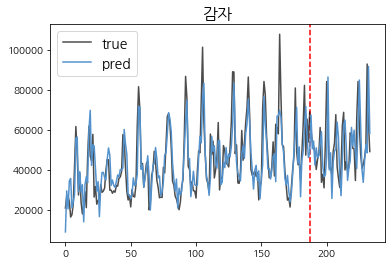

Crop Name: 고구마
32


Epoch:  100, average train loss: 0.196958, average valid loss: 0.198207
Epoch:  200, average train loss: 0.065099, average valid loss: 0.098527
Epoch   215: reducing learning rate of group 0 to 5.0000e-03.
Epoch:  300, average train loss: 0.058293, average valid loss: 0.132989
Epoch   316: reducing learning rate of group 0 to 2.5000e-03.
Epoch:  400, average train loss: 0.050970, average valid loss: 0.147038
Epoch   417: reducing learning rate of group 0 to 1.2500e-03.
Epoch:  500, average train loss: 0.044287, average valid loss: 0.156565


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
seq_length = 5

num_epochs = 4000
learning_rate = 1e-2

input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

fix_seed(SEED)

for i, crop in enumerate(progress_bar(crops)):
    print(f'Crop Name: {crop}')
    path = f'./results_0825/{crop}'
    make_single_directory(path)
    
    # construct the data
    i = len(crops) - 1
    print(i + 1)
    selected_data = scaler.fit_transform(df.iloc[:, i+1:i+2].values)
    X, y = sliding_windows(selected_data, seq_length)
    
    # train : test = 8 : 2
    train_size = int(len(y) * 0.8)
    test_size = len(y) - train_size
    
    X = torch.Tensor(np.array(X))
    y = torch.Tensor(np.array(y))

    X_train = torch.Tensor(np.array(X[:train_size]))
    y_train = torch.Tensor(np.array(y[:train_size]))

    X_test = torch.Tensor(np.array(X[train_size:]))
    y_test = torch.Tensor(np.array(y[train_size:]))

    # model and optimizer, scheduler
    model = LSTM(num_classes, input_size, hidden_size, num_layers)
    model.apply(init_weights)
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  
                                                           patience=100,
                                                           factor =0.5 ,
                                                           min_lr=1e-8, 
                                                           eps=1e-08,
                                                           verbose=True)
    # train the model
    avg_train_loss, avg_valid_loss = 0.0, 0.0
    best_loss = float('inf')
    train_losses, valid_losses = [], []
    for epoch in progress_bar(range(1, num_epochs + 1)):
        # training mode
        model.train()
        outputs = model(X_train)
        optimizer.zero_grad()

        train_loss = criterion(outputs, y_train)
        train_losses.append(train_loss.item())
        avg_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
        # evaluation mode
        model.eval()
        with torch.no_grad():
            valid = model(X_test)
            valid_loss = criterion(valid, y_test)
            valid_losses.append(valid_loss.item())
            avg_valid_loss += valid_loss.item()
        
        scheduler.step(valid_loss)
    
        # save the best model
        if (valid_loss.item() < best_loss) and epoch >= 500:
            torch.save(model, f'{path}/model_{crop}.pt')
            best_loss = valid_loss.item()
            #print(f'Save the best model at epoch {epoch}, best loss: {best_loss:.6f}')
                
        # print status
        if epoch % 100 == 0:
            avg_train_loss /= 100
            avg_valid_loss /= 100
            print(f'Epoch: {epoch:4d}, average train loss: {avg_train_loss:.6f}, average valid loss: {avg_valid_loss:.6f}')
            avg_train_loss, avg_valid_loss = 0.0, 0.0
        
    # load the model and infer
    best_model = torch.load(f'{path}/model_{crop}.pt')
    plot_result(best_model, X, y, crop, path)
    plot_loss(train_losses, valid_losses, crop, path)    